In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import seaborn as sns

In [3]:
import os
os.chdir('..')
os.getcwd()

'/gpfs/summit/scratch/dasr8731/needfinder'

In [4]:
import glob
import json
import string

import pandas as pd
import numpy as np


In [5]:
eval_dirpath = 'data/eval_set'
eval_results_path = 'data/autoeval_results.csv' 

In [6]:
groundtruth = []
files = glob.glob(os.path.join(eval_dirpath , '*.json'))
for f in files : 
    groundtruth.append(json.load(open(f)))

In [7]:
ids2quotes = {}
quotes2ids = {}

for res in groundtruth :
    title = res['title']
    ids2quotes[title] = {}

    for section in res['sections'] : 
        section_header = section['section_header']
        ids2quotes[title][section_header] = section['quotes']

        for quote in section['quotes'] : 

            quotes2ids[quote] = {'title' : title , 
                            'section' : section_header, 
                            }

                    
sentences = list(quotes2ids.keys())

In [8]:
def get_adjacent_quotes(query, section_quotes) : 
    
    query_index = section_quotes.index(query)
    is_last_quote = False
    is_first_quote = False
    
    if query_index == len(section_quotes)-1 : 
        is_last_quote = True
        
    if query_index == 0 : 
        is_first_quote = True
        

    if is_last_quote and is_first_quote : 
        return [None , None]
    
    elif is_last_quote and not is_first_quote:
        return [section_quotes[query_index-1] , None]
    
    elif is_first_quote and not is_last_quote : 
        return [None, section_quotes[query_index+1] ]
    
    else :
        return [section_quotes[query_index-1], section_quotes[query_index+1] ]

In [9]:
def check_relation(query, target) : 
    
    query_paper_title = quotes2ids[query]['title']
    query_paper_section = quotes2ids[query]['section']
    
    title_quotes = []
    for section_header , quotes in ids2quotes[query_paper_title].items() : 
        title_quotes.extend(quotes)
        
    section_quotes = ids2quotes[query_paper_title][query_paper_section]
    
    adjacent_quotes = get_adjacent_quotes(query, section_quotes)
    
    if target in adjacent_quotes :
        return 'adjacent'
    
    elif target==query : 
        return 'same_quote'
    
    elif target in section_quotes : 
        return 'same_section'
    
    elif target in title_quotes : 
        return 'same_paper' 
    
    else : 
        return 'different_paper'

In [10]:
results_df  = pd.read_csv(eval_results_path, index_col=0)

In [11]:
relation_dict = {'query' : [] ,
                'target' : [] , 
                'sim' : [] , 
                'relation' : [], 
                }

for query, row in results_df.iterrows() : 
    
    for target , sim in row.items() : 
    
        relation_dict['query'].append(query)
        relation_dict['target'].append(target)
        relation_dict['sim'].append(sim)
        relation_dict['relation'].append(check_relation(query, target))
    
relation_df = pd.DataFrame(relation_dict)

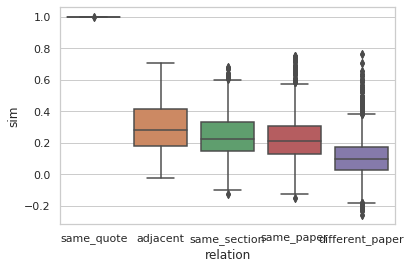

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(y=relation_df["sim"], x=relation_df["relation"])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [16]:
relation_df.to_csv('data/results-adjacency_vs_sim.csv' , index=False)